In [3]:
!pip install nltk
import nltk; nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from wordcloud import WordCloud

You should consider upgrading via the '/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cbeams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


You should consider upgrading via the '/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/bin/python -m pip install --upgrade pip' command.


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [5]:
# Import Dataset
df = pd.read_json('../raw_data/all_data_df_stripped.json')
df.head()

,full_transcript,artist,show_name,year,source,artist_birthday,artist_gender,age_then,full_transcript_clean
0,[rock music playing]\n\n[indistinct chatter]\n...,Adam Devine,Best Time Of Our Lives,2019.0,Scraps from the Loft,1983.0,2,36.0,man guy much seat guy jacked fully juiced man ...
1,"strong language. CHEERING Yes, yes, yes! How...",Adam Hess,Live from the BBC,2016.0,BBC,1990.0,2,26.0,yes yes yes lovely apologise state voice go co...
2,"Ladies and gentlemen, please welcome your hos...",Adam Hills,Live at the Apollo Series 9 Episode 4,2013.0,BBC,1970.0,2,43.0,tonight london london live amazing act present...
3,some strong language and adult humour Ladies...,Adam Hills,Live at the Apollo Series 12 Episode 4,2016.0,BBC,1970.0,2,46.0,tonight hair lost bet british paralympic team ...
4,"? CHEERING Hello, Apollo. I am going to start ...",Adam Hills,Live at the Apollo Series 5 Episode 5,2009.0,BBC,1970.0,2,39.0,start saying something probably never heard co...


In [6]:
nb_df = df[df['artist_gender']==3]

In [7]:
nb_df.head()

,full_transcript,artist,show_name,year,source,artist_birthday,artist_gender,age_then,full_transcript_clean
163,1. Opening Numbers\n\nWell… God! God! Jesus… E...,Eddie Izzard,Unrepeatable,1994.0,Scraps from the Loft,1962.0,3,32.0,opening number well god god jesus hello yes sh...
164,(AUDIENCE CHEERING) London! London! London. Lo...,Eddie Izzard,Stripped,2009.0,Scraps from the Loft,1962.0,3,47.0,london london london london london world excep...
165,"(Siren) Well, Times Square. I just had to do a...",Eddie Izzard,Glorious,1997.0,Scraps from the Loft,1962.0,3,35.0,time square show brilliant time square always ...
166,‘San Francisco. ‘Town city of gleaming spires....,Eddie Izzard,Dress To Kill,1999.0,Scraps from the Loft,1962.0,3,37.0,san francisco town city gleaming spire people ...
167,"Ladies and gentlemen, please welcome your hos...",Eddie Izzard,Live at the Apollo Series 9 Episode 1,2013.0,BBC,1962.0,3,51.0,tonight hammersmith greek god yes god trouser ...


In [8]:
# Convert to list
data = nb_df.full_transcript_clean.values.tolist()

pprint(data[:1])

['opening number well god god jesus hello yes showtime actually crummy '
 'beginning walking beginning worked really west end people expecting huge '
 'beginning something musical people first number even cast people hollywood '
 'always direction know shakespeare west end moody lighting old people saying '
 'shall meet tuesday okay back drop dime cauldron pinter west end people face '
 'different direction and sure read people widely read thinly read read fuck '
 'proud people read benoski book cat eating read anything partially dyslexic '
 'fully dyslexic met dyslexic partially dyslexic lot rivalry dyslexic camp '
 'rivvvalry bad handwriting mine place right rule advertising anyway '
 'advertising yes brought talk yes advertising looking realized certain people '
 'advertising area paid huge wad cash brown bag order subtly adjust mind old '
 'day much blatant advert day consumer realize sorry hit nowadays choice much '
 'choosy much aware buy advert subtle soft sell much like people 

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['opening', 'number', 'well', 'god', 'god', 'jesus', 'hello', 'yes', 'showtime', 'actually', 'crummy', 'beginning', 'walking', 'beginning', 'worked', 'really', 'west', 'end', 'people', 'expecting', 'huge', 'beginning', 'something', 'musical', 'people', 'first', 'number', 'even', 'cast', 'people', 'hollywood', 'always', 'direction', 'know', 'shakespeare', 'west', 'end', 'moody', 'lighting', 'old', 'people', 'saying', 'shall', 'meet', 'tuesday', 'okay', 'back', 'drop', 'dime', 'cauldron', 'pinter', 'west', 'end', 'people', 'face', 'different', 'direction', 'and', 'sure', 'read', 'people', 'widely', 'read', 'thinly', 'read', 'read', 'fuck', 'proud', 'people', 'read', 'benoski', 'book', 'cat', 'eating', 'read', 'anything', 'partially', 'dyslexic', 'fully', 'dyslexic', 'met', 'dyslexic', 'partially', 'dyslexic', 'lot', 'rivalry', 'dyslexic', 'camp', 'rivvvalry', 'bad', 'handwriting', 'mine', 'place', 'right', 'rule', 'advertising', 'anyway', 'advertising', 'yes', 'brought', 'talk', 'yes', 

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=5)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['opening', 'number', 'well', 'god', 'god', 'jesus', 'hello', 'yes', 'showtime', 'actually', 'crummy', 'beginning', 'walking', 'beginning', 'worked', 'really', 'west', 'end', 'people', 'expecting', 'huge', 'beginning', 'something', 'musical', 'people', 'first', 'number', 'even', 'cast', 'people', 'hollywood', 'always', 'direction', 'know', 'shakespeare', 'west', 'end', 'moody', 'lighting', 'old', 'people', 'saying', 'shall', 'meet', 'tuesday', 'okay', 'back', 'drop', 'dime', 'cauldron', 'pinter', 'west', 'end', 'people', 'face', 'different', 'direction', 'and', 'sure', 'read', 'people', 'widely', 'read', 'thinly', 'read', 'read', 'fuck', 'proud', 'people', 'read', 'benoski', 'book', 'cat', 'eating', 'read', 'anything', 'partially', 'dyslexic', 'fully', 'dyslexic', 'met', 'dyslexic', 'partially', 'dyslexic', 'lot', 'rivalry', 'dyslexic', 'camp', 'rivvvalry', 'bad', 'handwriting', 'mine', 'place', 'right', 'rule', 'advertising', 'anyway', 'advertising', 'yes', 'brought', 'talk', 'yes', '

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['opening', 'number', 'showtime', 'actually', 'crummy', 'begin', 'walk', 'begin', 'work', 'really', 'west', 'end', 'people', 'expect', 'huge', 'begin', 'musical', 'people', 'first', 'number', 'even', 'cast', 'people', 'always', 'direction', 'know', 'end', 'moody', 'light', 'old', 'people', 'say', 'meet', 'okay', 'back', 'drop', 'dime', 'end', 'people', 'face', 'different', 'direction', 'sure', 'read', 'people', 'widely', 'read', 'thinly', 'read', 'read', 'fuck', 'proud', 'people', 'read', 'book', 'cat', 'eat', 'read', 'partially', 'dyslexic', 'fully', 'dyslexic', 'meet', 'dyslexic', 'partially', 'dyslexic', 'lot', 'rivalry', 'rivvvalry', 'bad', 'handwriting', 'mine', 'place', 'right', 'rule', 'advertising', 'anyway', 'advertising', 'bring', 'talk', 'advertising', 'look', 'realize', 'certain', 'people', 'advertising', 'area', 'pay', 'huge', 'wad', 'cash', 'brown', 'bag', 'order', 'subtly', 'adjust', 'mind', 'old', 'day', 'much', 'blatant', 'advert', 'day', 'consumer', 'realize', 'sorry

In [13]:
def remove_stopw(text, word_list):
    for i in range(len(text)):
        text[i] = [w for w in text[i] if not w in word_list]
    return text

In [14]:
### additional words to remove from the scripts
words_to_remove = ['thank', 'cheering', 'recorded', 'applause', 'laughter', 'laughing', 'murmuring', 'chatter',
                       'aired', 'filmed', 'ladies', 'gentlemen', 'welcome', 'stage', 'transcript', 'netflix',
                  'apollo', 'like', 'goodnight', 'mutter', 'noo', 'nuh', 'oof', 'maan', 'cause', 'okay', 
                   'hey', 'also', 'someone', 'somebody', 'everybody', 'also', 'part' , 'sometimes', 'maybe', 
                   'three', 'second', 'everything', 'minute', 'name', 'kind', 'point', 'yeah', 'hello', 'one', 
                   'two', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'whine', 'hnn', 'malla', 'letta', 
                   'namoo', 'getta', 'nama', 'mana', 'chk','manoo', 'hadda', 'ama', 'carlin',
                  'go', 'know', 'host', 'goodnight', 'get', 'gon', 'think', 'say', 'right', 'look',
                  'thing', 'make', 'know', 'want', 'going', 'would', 'could', 'gentlemen', 'let', 'please',
                   'hbo', 'special' 'yes', 'take', 'say', 'got', 'come', 'see', 'really', 'tell',
                   'well', 'give', 'said', 'people', 'mean', 'even', 'never', 'way', 'happen', 'put', 'much',
                  'lot', 'ever', 'still', 'live', 'quite', 'sort', 'actually', 'use', 'tonight', 'find', 'always',
                  'time', 'good', 'back', 'show', 'little', 'big', 'day', 'talk', 'start', 'need', 'bad', 'first', 'great',
                  'try', 'year', 'word', 'turn', 'bring', 'feel', 'bit', 'ck', 'cke', 'gger', 'ckin', 'groan', 'groan_low', 'groan_high',
                  'high_groan', 'low_groan', 'dingdingde']
                    
                    # 'know'? 'go'? 'fuck'?
    
                    # haven't left 'i'm' etc. as those should be cleaned up
                    # by a mixture of stopwords, punctuation removeal, lemmatizing and minimum length

remove_stopw(data_lemmatized, stopwords.words('english'))
remove_stopw(data_lemmatized, words_to_remove)

[['opening',
  'number',
  'showtime',
  'crummy',
  'begin',
  'walk',
  'begin',
  'work',
  'west',
  'end',
  'expect',
  'huge',
  'begin',
  'musical',
  'number',
  'cast',
  'direction',
  'end',
  'moody',
  'light',
  'old',
  'meet',
  'drop',
  'dime',
  'end',
  'face',
  'different',
  'direction',
  'sure',
  'read',
  'widely',
  'read',
  'thinly',
  'read',
  'read',
  'fuck',
  'proud',
  'read',
  'book',
  'cat',
  'eat',
  'read',
  'partially',
  'dyslexic',
  'fully',
  'dyslexic',
  'meet',
  'dyslexic',
  'partially',
  'dyslexic',
  'rivalry',
  'rivvvalry',
  'handwriting',
  'mine',
  'place',
  'rule',
  'advertising',
  'anyway',
  'advertising',
  'advertising',
  'realize',
  'certain',
  'advertising',
  'area',
  'pay',
  'huge',
  'wad',
  'cash',
  'brown',
  'bag',
  'order',
  'subtly',
  'adjust',
  'mind',
  'old',
  'blatant',
  'advert',
  'consumer',
  'realize',
  'sorry',
  'hit',
  'nowadays',
  'choice',
  'choosy',
  'aware',
  'buy',
  

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 5), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 6), (13, 5), (14, 2), (15, 2), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 4), (23, 2), (24, 1), (25, 1), (26, 1), (27, 8), (28, 1), (29, 3), (30, 2), (31, 2), (32, 3), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 4), (47, 2), (48, 5), (49, 1), (50, 1), (51, 2), (52, 1), (53, 2), (54, 1), (55, 3), (56, 2), (57, 1), (58, 1), (59, 1), (60, 8), (61, 1), (62, 2), (63, 2), (64, 6), (65, 3), (66, 3), (67, 3), (68, 2), (69, 1), (70, 1), (71, 2), (72, 2), (73, 1), (74, 2), (75, 1), (76, 2), (77, 16), (78, 2), (79, 1), (80, 2), (81, 1), (82, 7), (83, 6), (84, 10), (85, 2), (86, 1), (87, 3), (88, 4), (89, 2), (90, 3), (91, 2), (92, 4), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 3), (102, 4), (103, 2), (104, 2), (105, 2), (106, 1), (107, 1), (108, 5), (109, 1), (110, 

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=31,
                                            random_state=100,
                                            update_every=10,
                                            chunksize=15,
                                            passes=10,
                                            alpha=0.4,
                                            eta=0.5,
                                            per_word_topics=True)

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(1,
  '0.000*"fuck" + 0.000*"work" + 0.000*"cat" + 0.000*"man" + 0.000*"film" + '
  '0.000*"eat" + 0.000*"guy" + 0.000*"idea" + 0.000*"stuff" + 0.000*"end"'),
 (5,
  '0.000*"fuck" + 0.000*"work" + 0.000*"guy" + 0.000*"fucking" + 0.000*"man" + '
  '0.000*"kid" + 0.000*"small" + 0.000*"french" + 0.000*"film" + 0.000*"idea"'),
 (14,
  '0.000*"fuck" + 0.000*"cat" + 0.000*"work" + 0.000*"film" + 0.000*"dog" + '
  '0.000*"bird" + 0.000*"man" + 0.000*"call" + 0.000*"car" + 0.000*"eat"'),
 (11,
  '0.004*"kraken" + 0.004*"pipe" + 0.003*"fit" + 0.003*"wise" + 0.003*"man" + '
  '0.002*"safe" + 0.002*"dressage" + 0.002*"cupboard" + 0.002*"noone" + '
  '0.002*"mind"'),
 (4,
  '0.000*"fuck" + 0.000*"man" + 0.000*"work" + 0.000*"film" + 0.000*"eat" + '
  '0.000*"dog" + 0.000*"cat" + 0.000*"fucking" + 0.000*"call" + 0.000*"car"'),
 (2,
  '0.000*"run" + 0.000*"fuck" + 0.000*"man" + 0.000*"eat" + 0.000*"cat" + '
  '0.000*"work" + 0.000*"fish" + 0.000*"film" + 0.000*"tree" + 0.000*"car"'),
 (13,
  '0.00

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.862235476250304

Coherence Score:  0.21012835969700705


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
vis

/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.030772  0.105507       1        1  78.316746
10     0.084250 -0.011732       2        1  17.808127
11    -0.027312  0.018194       3        1   3.330032
5     -0.003114 -0.003952       4        1   0.019476
3     -0.003124 -0.003995       5        1   0.019470
1     -0.003128 -0.003996       6        1   0.019469
19    -0.003133 -0.003992       7        1   0.019469
24    -0.003129 -0.003996       8        1   0.019468
28    -0.003125 -0.003994       9        1   0.019468
13    -0.003133 -0.003998      10        1   0.019468
22    -0.003133 -0.003997      11        1   0.019468
23    -0.003130 -0.003996      12        1   0.019468
27    -0.003130 -0.003997      13        1   0.019468
30    -0.003135 -0.004002      14        1   0.019468
7     -0.003133 -0.003999      15        1   0.019467
17    -0.003132 -0.003999      16        1   0.019467
8     -0.003135 -0.003999      17        1   0.019467
29    -0.003133 -0.004000      18        1   0.019467
20    -0.003136 -0.004004      19        1   0.019467
26    -0.003134 -0.004002      20        1   0.019467
14    -0.003130 -0.004001      21        1   0.019467
9     -0.003139 -0.004004      22        1   0.019467
2     -0.003137 -0.004001      23        1   0.019467
0     -0.003137 -0.004005      24        1   0.019467
4     -0.003133 -0.004000      25        1   0.019467
18    -0.003136 -0.004006      26        1   0.019467
12    -0.003138 -0.004004      27        1   0.019466
21    -0.003134 -0.004005      28        1   0.019466
16    -0.003134 -0.004008      29        1   0.019466
25    -0.003136 -0.004008      30        1   0.019465
15    -0.003138 -0.004010      31        1   0.019465, topic_info=              Term       Freq      Total Category  logprob  loglift
414           fuck  85.000000  85.000000  Default  30.0000  30.0000
588            man  63.000000  63.000000  Default  29.0000  29.0000
825            run  44.000000  44.000000  Default  28.0000  28.0000
1087          work  56.000000  56.000000  Default  27.0000  27.0000
415        fucking  35.000000  35.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
1024  transvestite   0.000695  26.365089  Topic31  -8.1860  -1.9989
1025          tree   0.000695  26.253054  Topic31  -8.1860  -1.9947
530           kill   0.000695  29.197674  Topic31  -8.1864  -2.1014
331            end   0.000695  29.404231  Topic31  -8.1864  -2.1084
46            away   0.000695  21.834892  Topic31  -8.1866  -1.8109

[2110 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
12        1  0.219542       advert
12        2  0.878170       advert
13        1  0.254317  advertising
13        2  0.762951  advertising
46        1  0.961763         away
...     ...       ...          ...
1085      2  0.102671        woman
1087      1  0.794971         work
1087      2  0.211992         work
1089      1  0.917489        world
1089      2  0.065535        world

[288 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 11, 12, 6, 4, 2, 20, 25, 29, 14, 23, 24, 28, 31, 8, 18, 9, 30, 21, 27, 15, 10, 3, 1, 5, 19, 13, 22, 17, 26, 16])

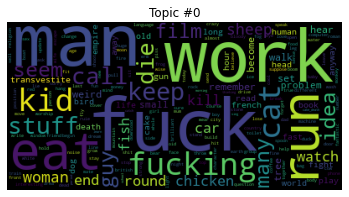

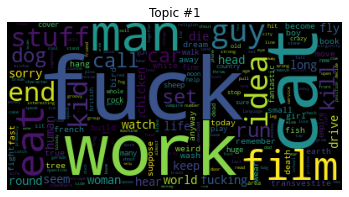

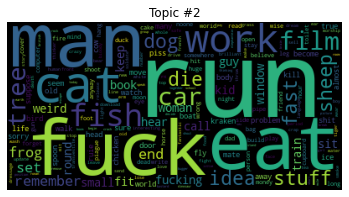

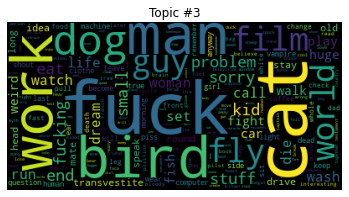

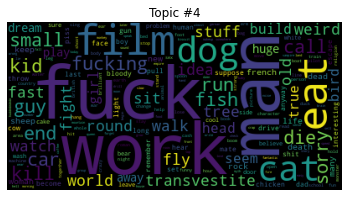

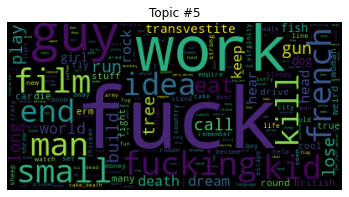

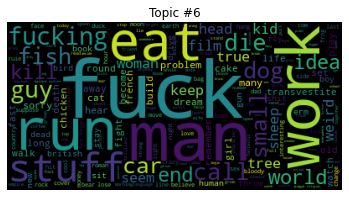

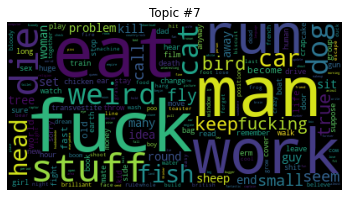

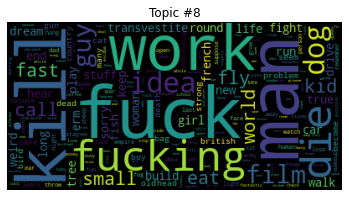

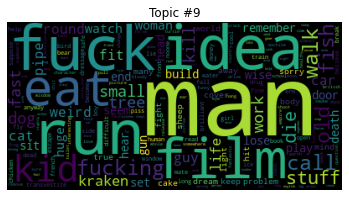

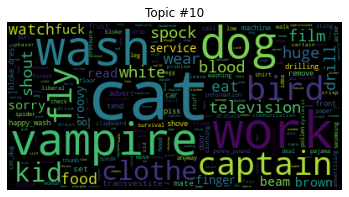

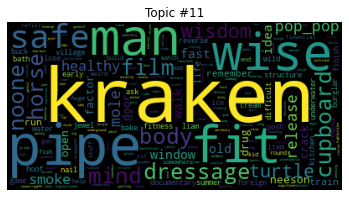

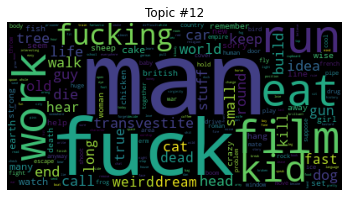

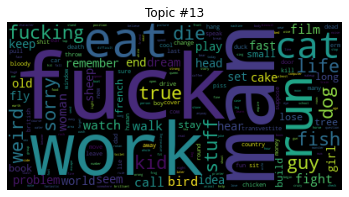

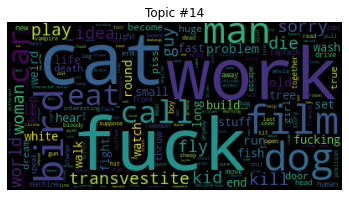

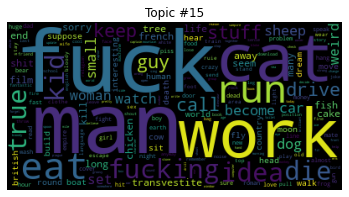

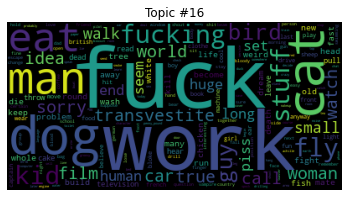

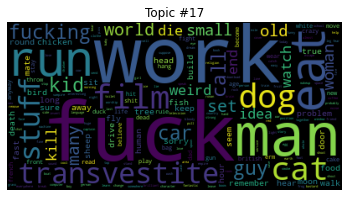

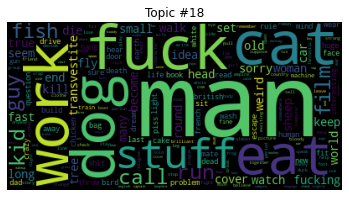

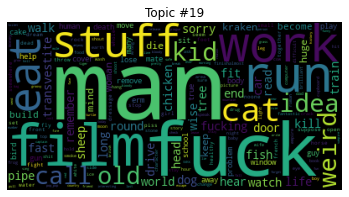

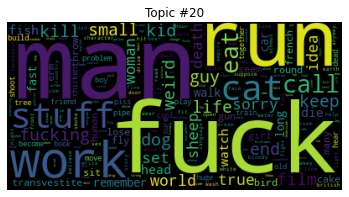

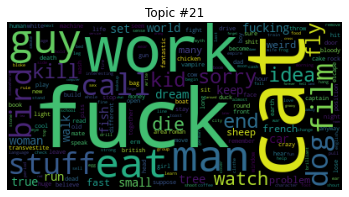

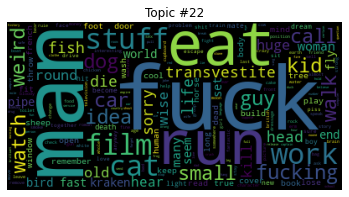

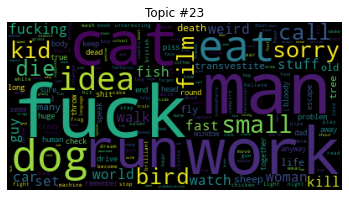

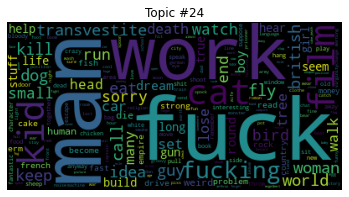

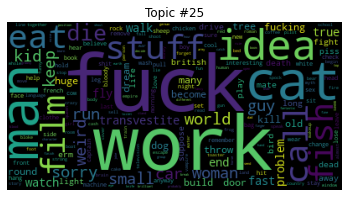

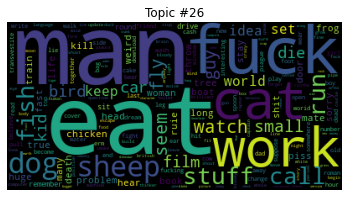

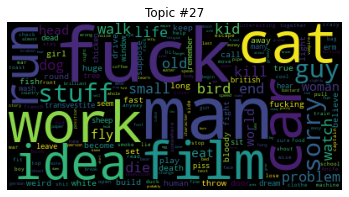

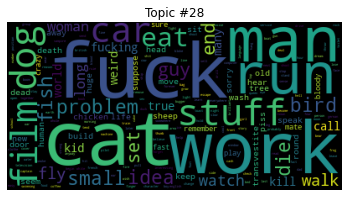

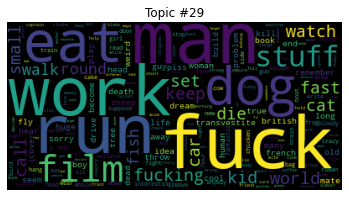

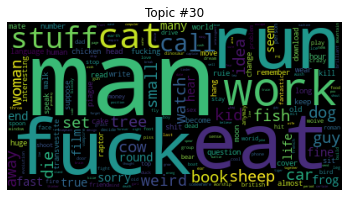

/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's docu

In [20]:
# lda is assumed to be the variable holding the LdaModel object
import matplotlib.pyplot as plt
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()